# Working with Data: `Dataset`, `DataLoader`, `Sampler`, and `Transforms`

These basic concepts make it easy to work with large data.

## Init, helpers, utils, ...

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
from IPython.core.debugger import set_trace

import utils  # little helpers

# Dataset
It's easy to create your `Dataset`,
but PyTorch comes with some
[build-in datasets](https://pytorch.org/docs/stable/torchvision/datasets.html):

- MNIST
- Fashion-MNIST
- KMNIST
- EMNIST
- FakeData
- COCO
  - Captions
  - Detection
- LSUN
- ImageFolder
- DatasetFolder
- Imagenet-12
- CIFAR
- STL10
- SVHN
- PhotoTour
- SBU
- Flickr
- VOC
- Cityscapes

`Dataset` gives you information about the number of samples (implement `__len__`) and gives you the sample at a given index (implement `__getitem__`.
It's a nice and simple abstraction to work with data.

In [4]:
from torch.utils.data import Dataset

```python
class Dataset(object):
    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```

The `ImageFolder` dataset is quite useful and follows the usual conventions for folder layouts:

```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

In [5]:
train_ds = utils.DogsCatsDataset("../data/raw", "sample/train")

Loading data from ../data/raw/dogscats/sample/train.


In [6]:
!tree -d ../data/raw/dogscats/

../data/raw/dogscats/
├── models
├── sample
│   ├── train
│   │   ├── cats
│   │   └── dogs
│   └── valid
│       ├── cats
│       └── dogs
├── test1
├── train
│   ├── cats
│   └── dogs
└── valid
    ├── cats
    └── dogs

15 directories


In [7]:
train_ds

Dataset DogsCatsDataset
    Number of datapoints: 16
    Root Location: ../data/raw/dogscats/sample/train
    Transforms (if any): None
    Target Transforms (if any): None

In [8]:
# the __len__ method
len(train_ds)

16

In [9]:
# the __getitem__ method
train_ds[0]

(<PIL.Image.Image image mode=RGB size=499x375 at 0x7F644469F8D0>, 0)

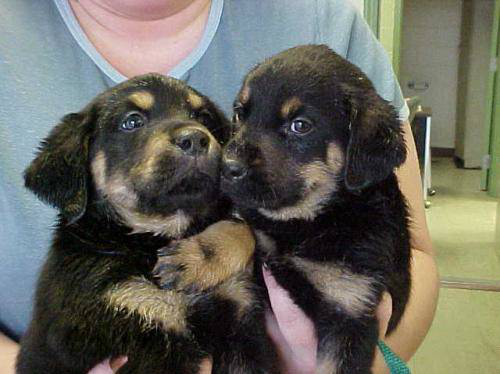

In [10]:
train_ds[14][0]

In [11]:
train_ds[14][1]

1

Optionally, some datasets offer convenience functions and attributes.
This is not enforced by the interface! Don't rely on it!

In [12]:
train_ds.classes

['cats', 'dogs']

In [13]:
train_ds.class_to_idx

{'cats': 0, 'dogs': 1}

In [14]:
train_ds.imgs

[('../data/raw/dogscats/sample/train/cats/cat.11737.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.2266.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.2921.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.3570.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.394.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.4600.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.4865.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.9021.jpg', 0),
 ('../data/raw/dogscats/sample/train/dogs/dog.1402.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.1614.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.2423.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.6391.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.6768.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.8091.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.8643.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.9077.jpg', 1)]

In [15]:
import random

1 dogs


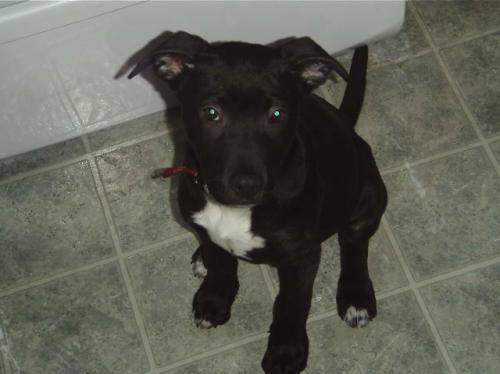

1 dogs


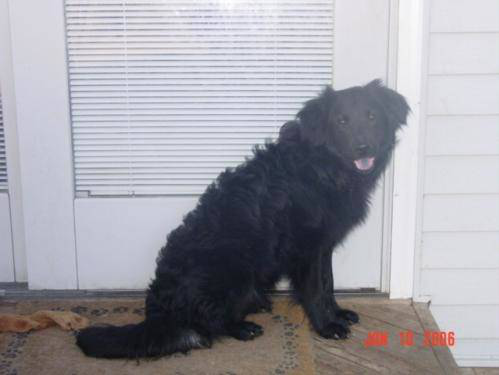

0 cats


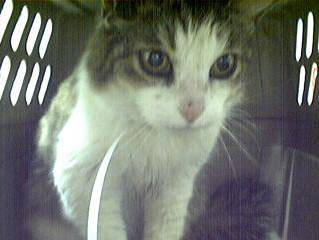

0 cats


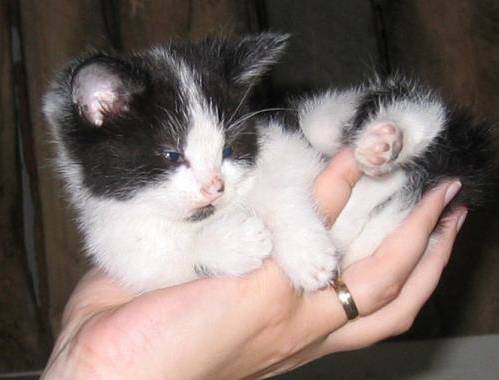

In [16]:
for img, label_id in random.sample(list(train_ds), 4):
    print(label_id, train_ds.classes[label_id])
    display(img)

# `torchvision.transforms`

Common image transformation that can be composed/chained [[docs]](https://pytorch.org/docs/stable/torchvision/transforms.html).

In [17]:
from torchvision import transforms

In [18]:
_image_size = 224
_mean = [0.485, 0.456, 0.406]
_std = [0.229, 0.224, 0.225]


trans = transforms.Compose([
    transforms.RandomCrop(_image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(.3, .3, .3),
    transforms.ToTensor(),
    transforms.Normalize(_mean, _std),
])

trans(train_ds[13][0])

tensor([[[ 1.5982,  1.8208,  1.8208,  ...,  2.2318,  2.2318,  2.2318],
         [ 1.5297,  1.7694,  1.8037,  ...,  2.2318,  2.2318,  2.2318],
         [ 1.4954,  1.7523,  1.8037,  ...,  2.2318,  2.2318,  2.2318],
         ...,
         [ 1.0159,  0.9988,  0.9646,  ..., -0.8678, -0.1828,  0.0741],
         [ 1.0159,  1.0159,  1.0159,  ..., -0.5424,  0.0227,  0.3309],
         [ 1.0159,  1.0159,  1.0331,  ..., -0.0801,  0.1768,  0.1768]],

        [[ 1.6583,  1.8859,  1.8859,  ...,  2.4111,  2.4111,  2.4111],
         [ 1.5882,  1.8333,  1.8683,  ...,  2.4111,  2.4111,  2.4111],
         [ 1.5532,  1.8158,  1.8683,  ...,  2.4111,  2.4111,  2.4111],
         ...,
         [ 1.1681,  1.1506,  1.1155,  ..., -0.8452, -0.1450,  0.0826],
         [ 1.1681,  1.1681,  1.1681,  ..., -0.5126,  0.0301,  0.3452],
         [ 1.1856,  1.1681,  1.1856,  ..., -0.0574,  0.2052,  0.1877]],

        [[ 1.6640,  1.8905,  1.8905,  ...,  2.6051,  2.6051,  2.5877],
         [ 1.5942,  1.8383,  1.8557,  ...,  2

## `torchvision.transforms.functional`

>Functional transforms give you fine-grained control of the transformation pipeline. As opposed to the transformations above, functional transforms don’t contain a random number generator for their parameters. That means you have to specify/generate all parameters, but you can reuse the functional transform. For example, you can apply a functional transform to multiple images like this:
>
> https://pytorch.org/docs/stable/torchvision/transforms.html#functional-transforms

```python
import torchvision.transforms.functional as TF
import random

def my_segmentation_transforms(image, segmentation):
    if random.random() > 5:
        angle = random.randint(-30, 30)
        image = TF.rotate(image, angle)
        segmentation = TF.rotate(segmentation, angle)
    # more transforms ...
    return image, segmentation
```

Ref:
- https://pytorch.org/docs/stable/torchvision/transforms.htm
- https://pytorch.org/docs/stable/torchvision/transforms.html#functional-transforms
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
- https://github.com/mdbloice/Augmentor
- https://github.com/aleju/imgaug

Shout-out:
- Hig performance image augmentation with pillow-simd [[github]](https://github.com/uploadcare/pillow-simd) [[benchmark]](http://python-pillow.org/pillow-perf/)
- Improving Deep Learning Performance with AutoAugment [[blog]](https://ai.googleblog.com/2018/06/improving-deep-learning-performance.html) [[paper]](https://arxiv.org/abs/1805.09501) [[pytorch implementation]](https://github.com/DeepVoltaire/AutoAugment)

# Dataloader
The `DataLoader` class offers batch loading of datasets with multi-processing and different sample strategies [[docs]](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

The signature looks something like this:
```python
DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    sampler=None,
    batch_sampler=None,
    num_workers=0,
    collate_fn=default_collate,
    pin_memory=False,
    drop_last=False,
    timeout=0,
    worker_init_fn=None
)
```

In [19]:
from torch.utils.data import DataLoader

In [20]:
train_ds = utils.DogsCatsDataset("../data/raw", "sample/train", transform=trans)
train_dl = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

Loading data from ../data/raw/dogscats/sample/train.


In [21]:
train_iter = iter(train_dl)
X, y = next(train_iter)

In [22]:
print("X:", X.shape)
print("y:", y.shape)

X: torch.Size([2, 3, 224, 224])
y: torch.Size([2])


Note that I passed `trans`, which returns `torch.Tensor`, not pillow images.
DataLoader expects tensors, numbers, dicts or lists.

In [23]:
_train_ds = utils.DogsCatsDataset("../data/raw", "sample/train") 
_train_dl = DataLoader(_train_ds, batch_size=2, shuffle=True)

try:
    for batch in _train_dl:
        pass
except TypeError as e:
    print(e)

Loading data from ../data/raw/dogscats/sample/train.
batch must contain tensors, numbers, dicts or lists; found <class 'PIL.Image.Image'>


## `collate_fn`
The `collate_fn` argument of `DataLoader` allows you to customize how single datapoints are put together into a batch.
`collate_fn` is a simple callable that gets a list of datapoints (i.e. what `dataset.__getitem__` returns).

Example of a custom `collate_fn`
(taken from [here](https://discuss.pytorch.org/t/how-to-create-a-dataloader-with-variable-size-input/8278/3)):

In [24]:
def my_collate_fn(list_of_x_y):
    data = [item[0] for item in list_of_x_y]
    target = [item[1] for item in list_of_x_y]
    target = torch.LongTensor(target)
    return [data, target]

# Sampler
`Sampler` define **how** to sample from the dataset [[docs]](https://pytorch.org/docs/stable/data.html#torch.utils.data.sampler.Sampler).

Examples:
- `SequentialSampler`
- `RandomSamples`
- `SubsetSampler`
- `WeightedRandomSampler`

Write your own by simply implementing `__iter__` to iterate over the indices of the dataset.

```python
class Sampler(object):
    def __init__(self, data_source):
        pass

    def __iter__(self):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError
```

# Recap
- `Dataset`: get one datapoint
- `transforms`: composable transformations
- `DataLoader`: combine single datapoints into batches (plus multi processing and more)
- `Sampler`: **how** to sample from a dataset

**Simple but extensible interfaces**

# Exercise
Go out and play:

- Maybe extend the `DogsCatsDataset` such that you can specify the size of dataset, i.e. the number of samples.
- Maybe try the `Subset` [[docs]](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset) to create smaller datasets.
- Maybe create `SubsetFraction` where you can specify the size of the dataset (between 0. and 1.).
- Maybe write a custom collate function for the `DogsCatsDataset` that turns it into a dataset appropriate to use in an autoencoder settings.

In [25]:
def autoencoder_collate_fn(list_of_x_y):
    # TODO implement me
    pass

In [26]:
class MyDataSet(Dataset):
    def __init__(self):
        super().__init__()
        # TODO implement me
    
    def __len__(self):
        # TODO implement me
        pass
    
    def __getitem__(self, idx):
        # TODO implement me
        pass